<html>
    <header>
        <body> 
            <font size="6">1. Cargar librerías a utilizar </font>
        </body>
    </header>
</html>

In [62]:
import sys, os, json
import time
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Integer, Categorical


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)

seed = 42

### Definición de funciones

In [30]:
def boxplots_data(data):
    for var in data:

        x = data[var].values

        # Se crea el espacio para los gráficos
        fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(10, 4))
        # Se grafica el boxplot

        ax1.boxplot(x)
        ax1.set_title( 'Boxplot for {}'.format(var) )

        # Se grafica el histograma

        ax2.hist(x, bins=30)
        ax2.set_title( 'Histogram for {}'.format(var) )
        plt.show()

<html>
    <header> <br>
        <body> 
            <font size="6">2. Lectura de insumos </font><br>
        </body>
    </header>
</html>

In [31]:
df = pd.read_csv("src/patient_priority.csv",sep=",",index_col=0)
df.dropna(subset=["triage"],inplace=True)
df.dropna(subset=["gender"],inplace=True)
df_y = df[["triage"]]
df.drop(["triage"], axis=1, inplace=True)
df.head(5)

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked
1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked
2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked
3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked
4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked


<html>
    <header> <br>
        <body> 
            <font size="6">3. Descriptivo de variables </font><br><br>
        </body>
    </header>
</html>

### Cantidad de registros y columnas

In [32]:
print(f"{df.shape[0]} Registros y {df.shape[1]} Columnas")

6551 Registros y 16 Columnas


### Información general

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6551 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6551 non-null   float64
 1   gender             6551 non-null   float64
 2   chest pain type    6551 non-null   float64
 3   blood pressure     6551 non-null   float64
 4   cholesterol        6551 non-null   float64
 5   max heart rate     6551 non-null   float64
 6   exercise angina    6551 non-null   float64
 7   plasma glucose     6551 non-null   float64
 8   skin_thickness     6551 non-null   float64
 9   insulin            6551 non-null   float64
 10  bmi                6551 non-null   float64
 11  diabetes_pedigree  6551 non-null   float64
 12  hypertension       6551 non-null   float64
 13  heart_disease      6551 non-null   float64
 14  Residence_type     6551 non-null   object 
 15  smoking_status     6551 non-null   object 
dtypes: float64(14), object(2

### Descriptivo variables numéricas

In [34]:
df.select_dtypes(include=['int64','float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
age,6551.0,58.231720,11.808809,28.000,49.000000,57.000000,66.000000,82.00
gender,6551.0,0.533659,0.498904,0.000,0.000000,1.000000,1.000000,1.00
chest pain type,6551.0,0.560678,1.285363,0.000,0.000000,0.000000,0.000000,4.00
blood pressure,6551.0,110.494734,21.634054,60.000,93.000000,113.000000,128.000000,165.00
cholesterol,6551.0,185.340253,32.597660,150.000,164.000000,179.000000,193.000000,294.00
max heart rate,6551.0,163.416730,15.452099,138.000,150.000000,163.000000,177.000000,202.00
exercise angina,6551.0,0.065334,0.247132,0.000,0.000000,0.000000,0.000000,1.00
plasma glucose,6551.0,98.646630,28.946424,55.120,78.800000,93.040000,111.800000,199.00
skin_thickness,6551.0,57.040910,22.955979,21.000,36.000000,56.000000,77.000000,99.00
insulin,6551.0,111.098764,17.445055,81.000,97.000000,111.000000,125.000000,171.00


### Descriptivo variables categóricas

In [35]:
df.select_dtypes(include=['object']).describe()

,Residence_type,smoking_status
count,6551,6551
unique,2,4
top,Urban,never smoked
freq,4187,3543


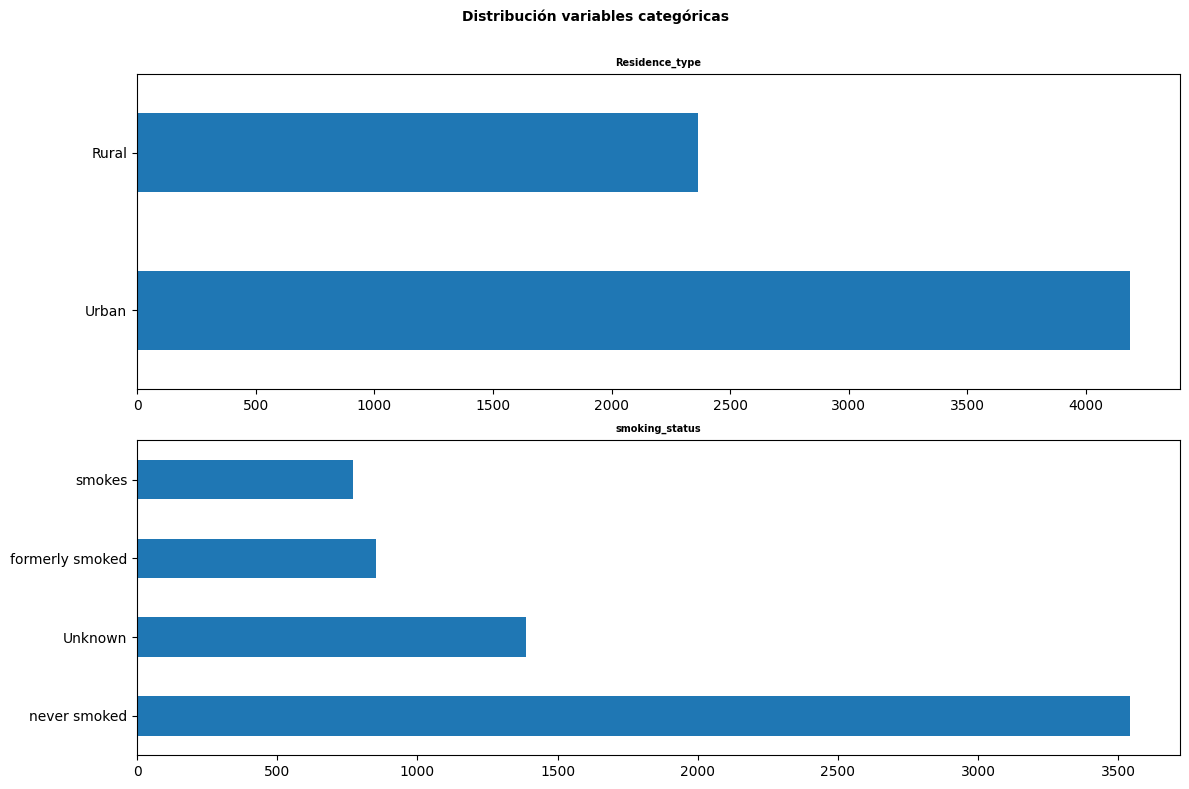

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables categóricas',
             fontsize = 10, fontweight = "bold");

### Valores nulos

In [37]:
df.isna().sum().sort_values(ascending=False)

age                  0
gender               0
chest pain type      0
blood pressure       0
cholesterol          0
max heart rate       0
exercise angina      0
plasma glucose       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
hypertension         0
heart_disease        0
Residence_type       0
smoking_status       0
dtype: int64

In [38]:
df.dropna(inplace=True)

### Boxplots e Histogramas

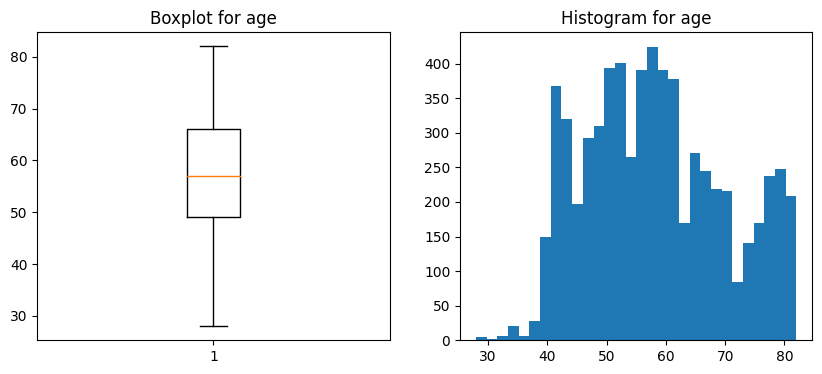

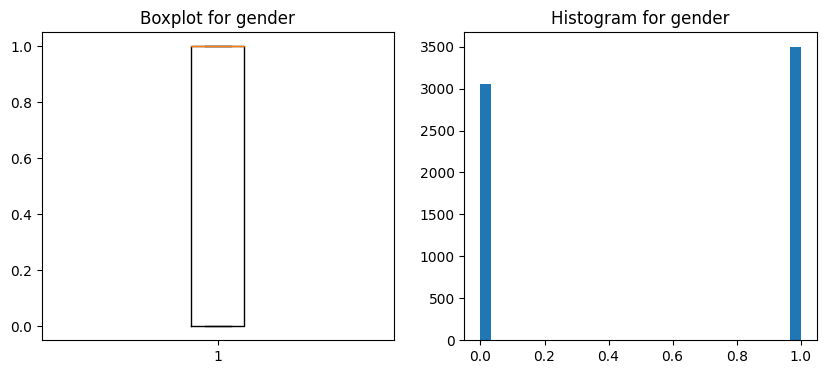

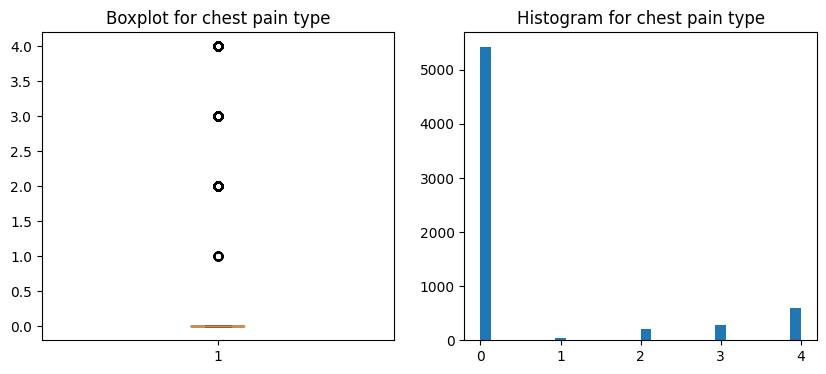

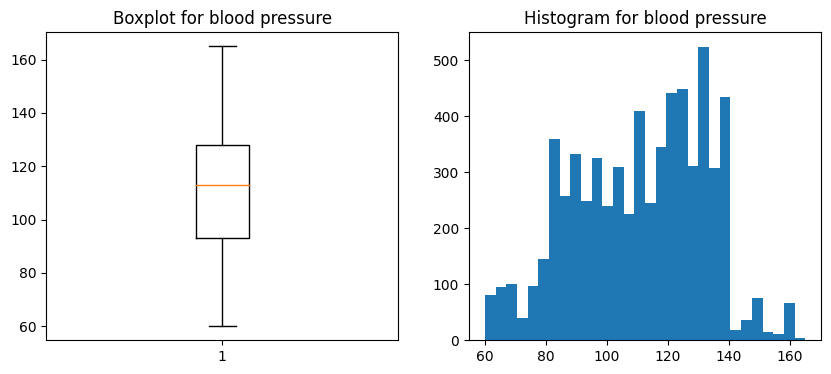

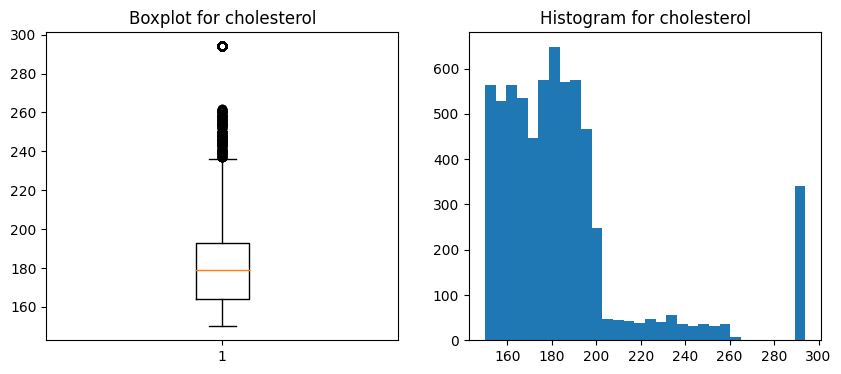

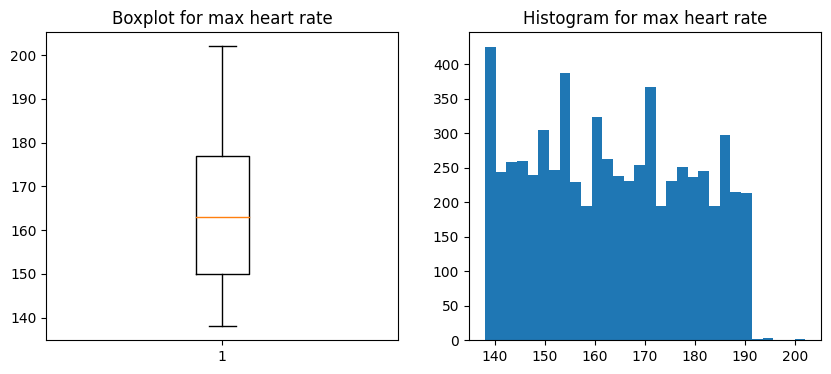

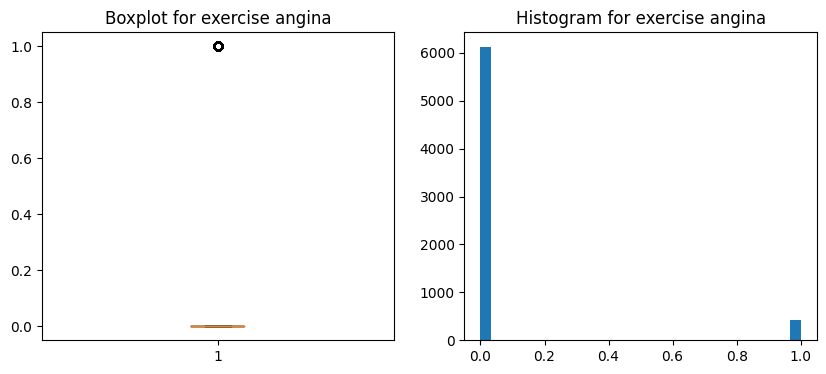

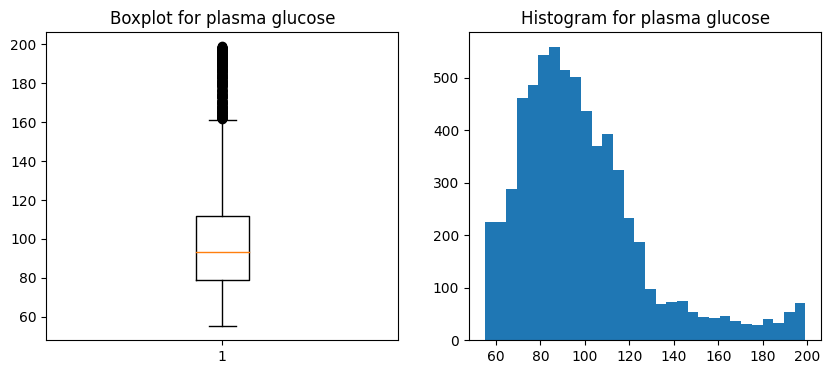

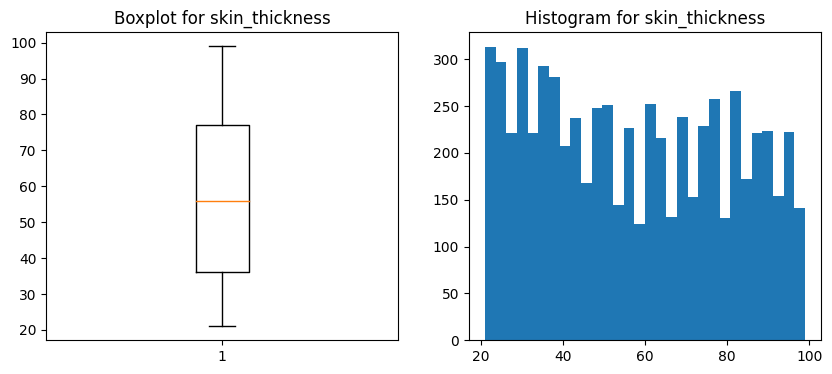

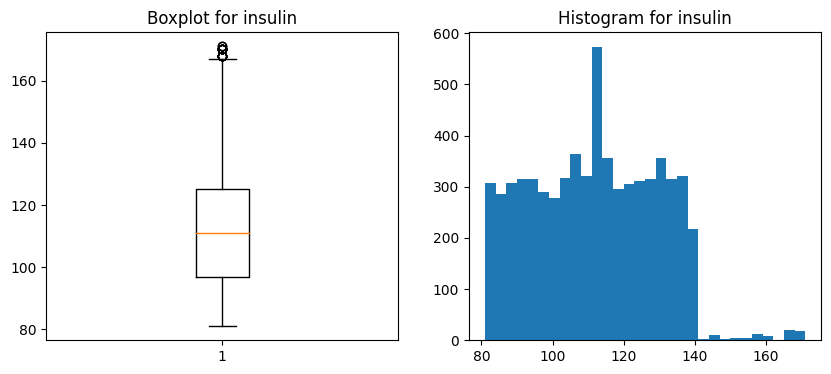

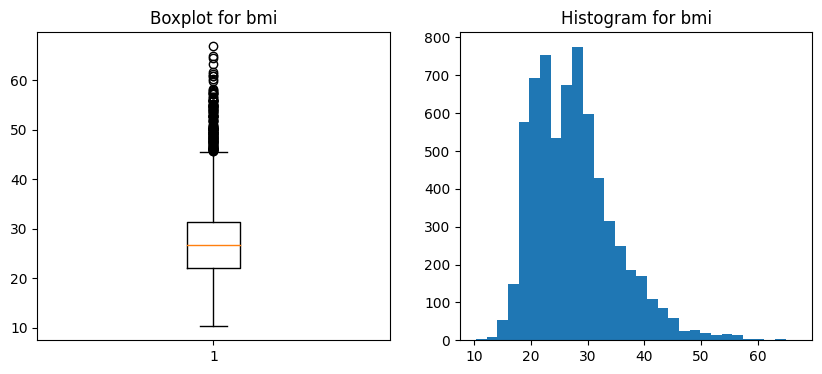

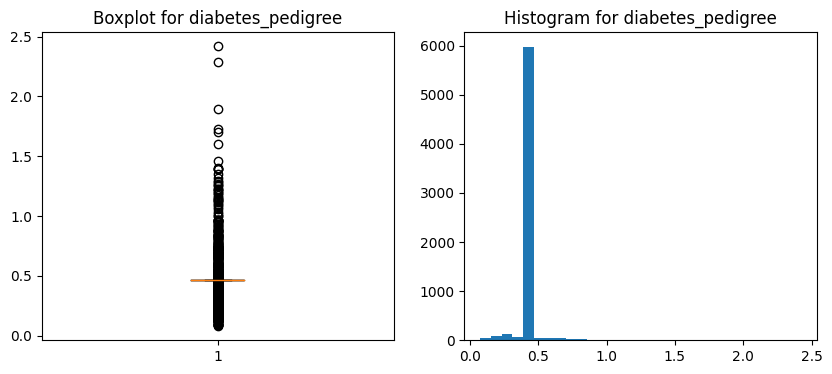

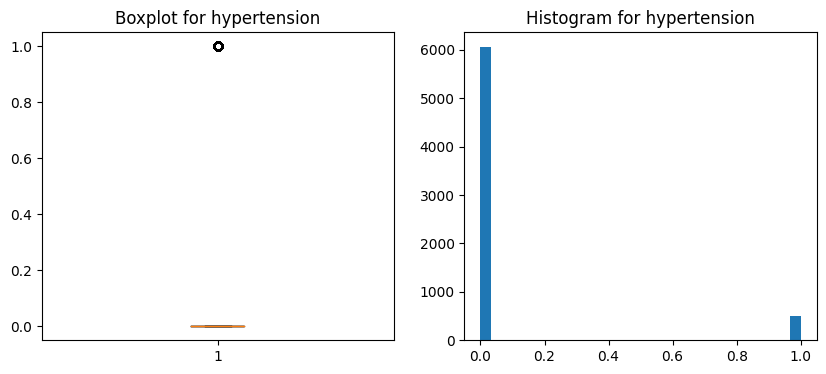

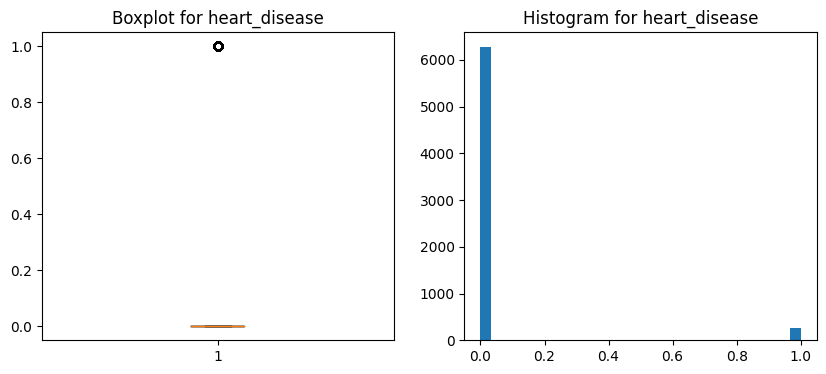

In [39]:
boxplots_data(df.select_dtypes(include=['int64','float64']))

<html>
    <header> <br>
        <body> 
            <font size="6">4. Transformación de variables categóricas</font><br><br>
        </body>
    </header>
</html>

In [40]:
residence_replace = {'Rural': 0,
                     'Urban': 1}

smoking_replace = {'Unknown': 0,
                   'never smoked': 1,
                   'formerly smoked': 2,
                   'smokes': 3}

df['Residence_type'] = (
    df['Residence_type']
    .map(residence_replace) 
    .fillna(df['Residence_type'])
)

df['smoking_status'] = (
    df['smoking_status']
    .map(smoking_replace) 
    .fillna(df['smoking_status'])
)

In [41]:
df.Residence_type = df.Residence_type.astype(int)
df.smoking_status = df.smoking_status.astype(int)

In [42]:
triage_replace = {'yellow': 0,
                  'green': 1,
                  'orange': 2,
                  'red': 3}

df_y['triage'] = (
    df_y['triage']
    .map(triage_replace) 
    .fillna(df_y['triage'])
)

C:\Users\PC\AppData\Local\Temp\ipykernel_7724\1845755947.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y['triage'] = (


In [44]:
df_y.value_counts()

triage
0         5636
1          440
2          346
3          129
dtype: int64

### Descriptivo variables 

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6551 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6551 non-null   float64
 1   gender             6551 non-null   float64
 2   chest pain type    6551 non-null   float64
 3   blood pressure     6551 non-null   float64
 4   cholesterol        6551 non-null   float64
 5   max heart rate     6551 non-null   float64
 6   exercise angina    6551 non-null   float64
 7   plasma glucose     6551 non-null   float64
 8   skin_thickness     6551 non-null   float64
 9   insulin            6551 non-null   float64
 10  bmi                6551 non-null   float64
 11  diabetes_pedigree  6551 non-null   float64
 12  hypertension       6551 non-null   float64
 13  heart_disease      6551 non-null   float64
 14  Residence_type     6551 non-null   int32  
 15  smoking_status     6551 non-null   int32  
dtypes: float64(14), int32(2)

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6551.0,58.231720,11.808809,28.000,49.000000,57.000000,66.000000,82.00
gender,6551.0,0.533659,0.498904,0.000,0.000000,1.000000,1.000000,1.00
chest pain type,6551.0,0.560678,1.285363,0.000,0.000000,0.000000,0.000000,4.00
blood pressure,6551.0,110.494734,21.634054,60.000,93.000000,113.000000,128.000000,165.00
cholesterol,6551.0,185.340253,32.597660,150.000,164.000000,179.000000,193.000000,294.00
max heart rate,6551.0,163.416730,15.452099,138.000,150.000000,163.000000,177.000000,202.00
exercise angina,6551.0,0.065334,0.247132,0.000,0.000000,0.000000,0.000000,1.00
plasma glucose,6551.0,98.646630,28.946424,55.120,78.800000,93.040000,111.800000,199.00
skin_thickness,6551.0,57.040910,22.955979,21.000,36.000000,56.000000,77.000000,99.00
insulin,6551.0,111.098764,17.445055,81.000,97.000000,111.000000,125.000000,171.00


<html>
    <header> <br>
        <body> 
            <font size="6">5. Análisis correlacional</font><br><br>
        </body>
    </header>
</html>

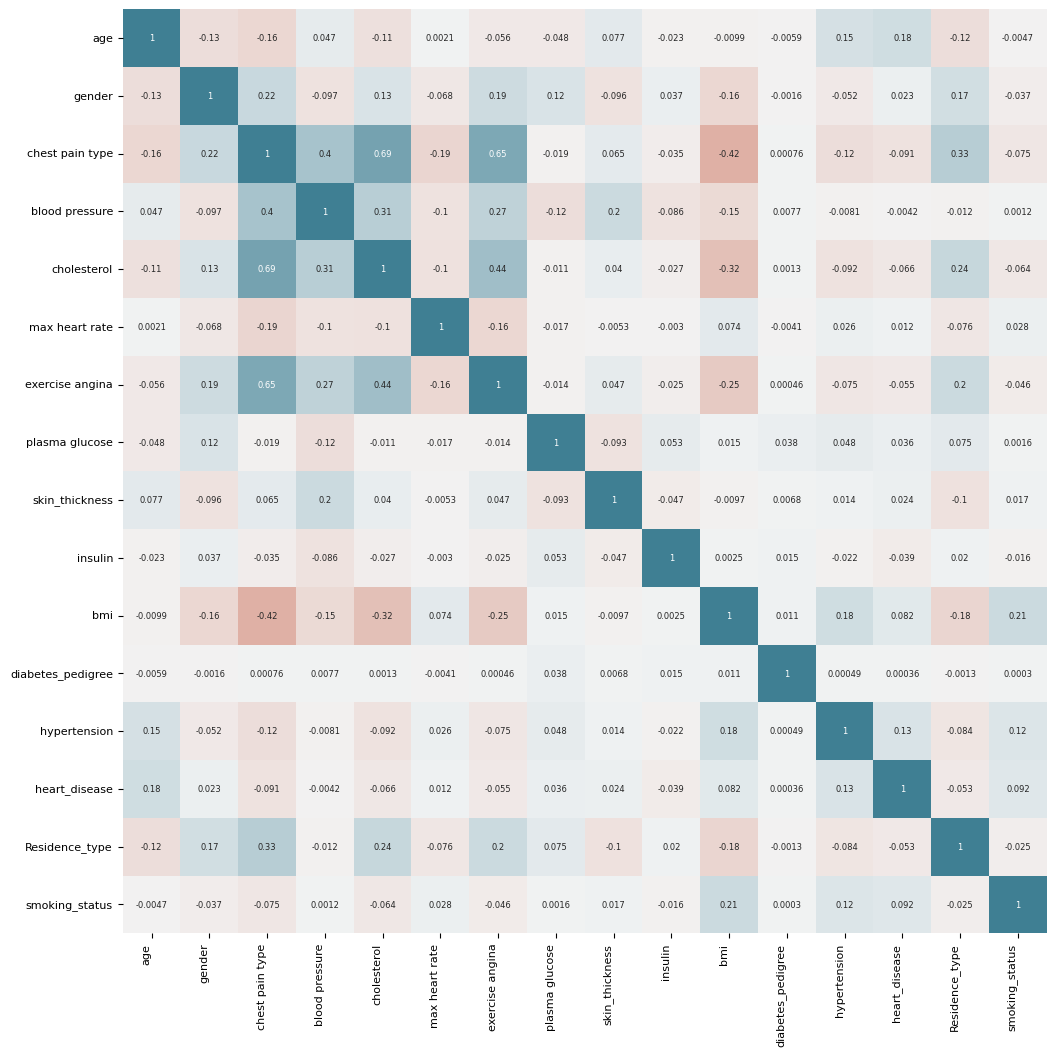

In [47]:
corr_matrix = df.corr(method='pearson')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 90,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

<html>
    <header> <br>
        <body> 
            <font size="6">6. Análisis por variables</font><br><br>
        </body>
    </header>
</html>

In [48]:
df.groupby(["Residence_type"]).mean()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,smoking_status
Residence_type,,,,,,,,,,,,,,,
0,60.084602,0.417513,0.000000,110.828257,175.043993,164.972081,0.000000,95.751248,60.214890,110.644670,29.339594,0.467386,0.104484,0.055838,1.183164
1,57.185574,0.599236,0.877239,110.306425,191.153571,162.538572,0.102221,100.281376,55.248866,111.355147,26.553833,0.467120,0.058514,0.033676,1.136613


In [49]:
df.groupby(["smoking_status"]).mean()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type
smoking_status,,,,,,,,,,,,,,,
0,60.601732,0.454545,0.000000,110.780664,174.881674,164.391053,0.000000,94.541349,59.865079,110.785714,26.511760,0.467386,0.036797,0.033911,0.501443
1,56.454699,0.602879,1.036692,110.301157,194.521310,162.406153,0.120802,101.297265,54.716624,111.580299,26.478380,0.467072,0.064917,0.025402,0.744567
2,61.822978,0.468933,0.000000,110.535756,174.335287,164.137163,0.000000,96.323763,59.858148,110.487691,31.005158,0.467386,0.138335,0.089097,0.516999
3,58.163849,0.429129,0.000000,110.825748,174.097529,165.517555,0.000000,96.410117,59.534460,110.122237,30.603511,0.467386,0.120936,0.078023,0.537061


In [50]:
df.groupby(["gender"]).mean()

,age,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
gender,,,,,,,,,,,,,,,
0.0,59.811129,0.256628,112.745008,180.909329,164.535188,0.015385,94.800108,59.397054,110.401309,28.840786,0.467386,0.089689,0.036661,0.549264,1.188216
1.0,56.851545,0.826373,108.528318,189.212243,162.439359,0.108982,102.007935,54.981979,111.708238,26.439102,0.467068,0.062357,0.046053,0.717677,1.122998


In [51]:
df.groupby(["hypertension"]).mean()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,heart_disease,Residence_type,smoking_status
hypertension,,,,,,,,,,,,,,,
0.0,57.727513,0.541013,0.606206,110.544809,186.192111,163.301040,0.070639,98.254082,56.948011,111.207130,27.177207,0.467202,0.034494,0.650602,1.124113
1.0,64.441057,0.443089,0.000000,109.878049,174.849593,164.841463,0.000000,103.480874,58.184959,109.764228,32.262195,0.467386,0.130081,0.497967,1.514228


In [52]:
df.groupby(["heart_disease"]).mean()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,Residence_type,smoking_status
heart_disease,,,,,,,,,,,,,,,
0.0,57.779548,0.531220,0.585059,110.513858,185.787831,163.378783,0.068175,98.426352,56.927525,111.241160,27.432606,0.467209,0.068175,0.644473,1.136349
1.0,68.630037,0.589744,0.000000,110.054945,175.047619,164.289377,0.000000,103.712198,59.648352,107.824176,30.468132,0.467386,0.234432,0.516484,1.545788


In [53]:
df.groupby(["Residence_type"]).sum()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,smoking_status
Residence_type,,,,,,,,,,,,,,,
0,142040.0,987.0,0.0,261998.0,413804.0,389994.0,0.0,226355.95,142348.0,261564.0,69358.8,1104.900537,247.0,132.0,2797
1,239436.0,2509.0,3673.0,461853.0,800360.0,680549.0,428.0,419878.12,231327.0,466244.0,111180.9,1955.832122,245.0,141.0,4759


In [54]:
df.groupby(["smoking_status"]).sum()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type
smoking_status,,,,,,,,,,,,,,,
0,83994.0,630.0,0.0,153542.0,242386.0,227846.0,0.0,131034.31,82973.0,153549.0,36745.3,647.797015,51.0,47.0,695
1,200019.0,2136.0,3673.0,390797.0,689189.0,575405.0,428.0,358896.21,193861.0,395329.0,93812.9,1654.835529,230.0,90.0,2638
2,52735.0,400.0,0.0,94287.0,148708.0,140009.0,0.0,82164.17,51059.0,94246.0,26447.4,398.680270,118.0,76.0,441
3,44728.0,330.0,0.0,85225.0,133881.0,127283.0,0.0,74139.38,45782.0,84684.0,23534.1,359.419845,93.0,60.0,413


In [55]:
df.groupby(["gender"]).sum()

,age,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
gender,,,,,,,,,,,,,,,
0.0,182723.0,784.0,344436.0,552678.0,502655.0,47.0,289614.33,181458.0,337276.0,88108.6,1427.864273,274.0,112.0,1678,3630
1.0,198753.0,2889.0,379415.0,661486.0,567888.0,381.0,356619.74,192217.0,390532.0,92431.1,1632.868386,218.0,161.0,2509,3926


In [56]:
df.groupby(["hypertension"]).sum()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,heart_disease,Residence_type,smoking_status
hypertension,,,,,,,,,,,,,,,
0.0,349771.0,3278.0,3673.0,669791.0,1128138.0,989441.0,428.0,595321.48,345048.0,673804.0,164666.7,2830.778740,209.0,3942,6811
1.0,31705.0,218.0,0.0,54060.0,86026.0,81102.0,0.0,50912.59,28627.0,54004.0,15873.0,229.953919,64.0,245,745


In [57]:
df.groupby(["heart_disease"]).sum()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,Residence_type,smoking_status
heart_disease,,,,,,,,,,,,,,,
0.0,362740.0,3335.0,3673.0,693806.0,1166376.0,1025692.0,428.0,617920.64,357391.0,698372.0,172221.9,2933.136277,428.0,4046,7134
1.0,18736.0,161.0,0.0,30045.0,47788.0,44851.0,0.0,28313.43,16284.0,29436.0,8317.8,127.596382,64.0,141,422


<html>
    <header> <br>
        <body> 
            <font size="6">7. Normalización</font><br><br>
        </body>
    </header>
</html>

In [60]:
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df)
df_x_scaled = pd.DataFrame(df_x_scaled, columns = df.columns)
df_x_scaled.head(5)

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status
0,-1.544026,0.934803,1.119865,1.363938,3.333615,0.555518,-0.264387,0.323152,-0.611692,-1.094879,-1.156160,0.001733,-0.284959,-0.208531,0.751402,-0.172843
1,-0.781825,-1.069745,1.897914,2.288477,-0.163836,-0.480019,-0.264387,-0.816973,-0.437432,-1.209533,-1.291240,0.001733,-0.284959,-0.208531,0.751402,-0.172843
2,-1.798093,0.934803,1.119865,0.901669,3.333615,-0.480019,-0.264387,-0.022341,-0.176042,-0.521607,-0.615842,0.001733,-0.284959,-0.208531,0.751402,-0.172843
3,-0.866514,-1.069745,2.675964,1.271485,0.879264,-0.480019,3.782337,-0.920620,-0.263172,0.395629,-1.291240,0.001733,-0.284959,-0.208531,0.751402,-0.172843
4,-0.358380,0.934803,1.897914,1.826208,0.296355,-0.480019,-0.264387,0.323152,1.435862,-1.610824,-0.886001,0.001733,-0.284959,-0.208531,0.751402,-0.172843


### Validamos el efecto de la categorización y la normalización en la correlación de los datos

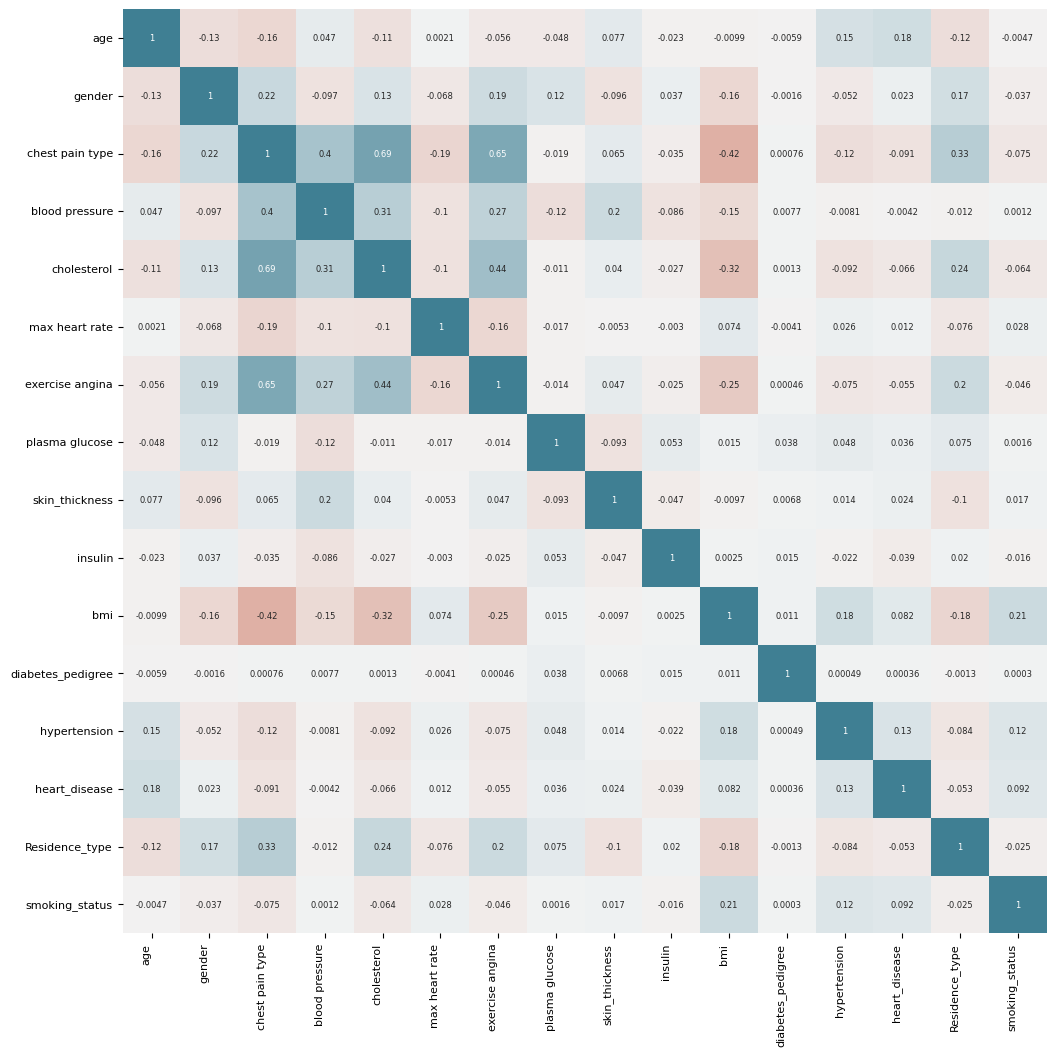

In [61]:
corr_matrix = df_x_scaled.corr(method='pearson')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 90,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

<html>
    <header> <br>
        <body> 
            <font size="6">8. Implementación de algoritmo: Regresión Logística</font><br><br>
        </body>
    </header>
</html>

<html>
    <header> <br>
        <body> 
            <font size="5">7.1 Implementación inicial con parámetros por defecto</font><br><br>
        </body>
    </header>
</html>

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_x_scaled, df_y, test_size=0.3, random_state=seed)

In [68]:
X = X_train.values
y = np.ravel(y_train.values)

# Creamos un modelo de regresión logística
lr = LogisticRegression(random_state=seed)

# Realizamos cross-validation con 5 folds
scores = cross_val_score(lr, X, y, cv=5)

# Imprimimos los resultados de cada fold y la precisión media
print("Recall por fold: ", scores)
print("Recall medio: ", scores.mean())

D:\Ambientes Virtuales\env_maestria\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Ambientes Virtuales\env_maestria\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Recall por fold:  [0.95856052 0.95310796 0.96401309 0.95310796 0.95419847]
Recall medio:  0.95659760087241


D:\Ambientes Virtuales\env_maestria\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lrmodel = LogisticRegression(random_state=seed)
lrmodel.fit(X, y)

y_pred = lrmodel.predict(X_test.values)

recall = metrics.recall_score(y_test, y_pred, average='macro')
print(recall)

In [ ]:
recall = metrics.recall_score(y_test, y_pred)
print(recall)

In [ ]:
matriz_confusion = metrics.classification_report(y_test, y_pred) 
print(matriz_confusion)

<html>
    <header> <br>
        <body> 
            <font size="5">7.2 Búsqueda de hiperparámetros por algoritmo genético</font><br><br>
        </body>
    </header>
</html>

In [ ]:
lrmodel_tuning = LogisticRegression(random_state=seed)

mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.01)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.01)

param_grid = {'tol'      : Continuous(0.00005, 0.0005),
              'solver'   : Categorical(['lbfgs', 'liblinear', 'saga']),
              'max_iter' : Integer(50, 200)}

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

evolved_estimator = GASearchCV(estimator=lrmodel_tuning,
                               cv=cv,
                               scoring='recall',
                               population_size=25,
                               generations=35,
                               mutation_probability=mutation_adapter,
                               crossover_probability=crossover_adapter,
                               param_grid=param_grid,
                               n_jobs=-1)

evolved_estimator.fit(X, y)

y_predict_ga = evolved_estimator.predict(X_test.values)

In [ ]:
print(evolved_estimator.best_params_)

In [ ]:
recall = metrics.recall_score(y_test, y_predict_ga, average='macro')
print(recall)

In [ ]:
matriz_confusion = metrics.classification_report(y_test, y_predict_ga) 
print(matriz_confusion)